# GPU Setup & Verification

In [ ]:
# Verify GPU availability
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and will be used for training")
else:
    print("⚠️ No GPU detected - training will use CPU (slower)")

In [ ]:
# Enable mixed precision for faster training on GPU
from tensorflow.keras import mixed_precision

# Set mixed precision policy for speed-up on GPU
mixed_precision.set_global_policy("mixed_float16")
print("✅ Mixed precision enabled (FP16) for faster GPU training")

# Dataset Loading

In [4]:
import kagglehub
import os

path = kagglehub.dataset_download("crawford/emnist")
print("Dataset path:", path)

Using Colab cache for faster access to the 'emnist' dataset.
Dataset path: /kaggle/input/emnist


In [ ]:
import pandas as pd
import numpy as np

# Use the path from kagglehub download
dataset_path = path

# Use the balanced split (digits + merged letters)
train_data = pd.read_csv(f"{dataset_path}/emnist-balanced-train.csv")
test_data  = pd.read_csv(f"{dataset_path}/emnist-balanced-test.csv")

# Load label mapping (index -> ASCII code) to keep character names consistent
mapping = np.loadtxt(f"{dataset_path}/emnist-balanced-mapping.txt", delimiter=" ", dtype=int)
label_map = [chr(m[1]) for m in mapping]  # e.g., ['0', '1', ..., 'A', ...]
num_classes = len(label_map)

print("Classes:", num_classes)
print(train_data.shape)
print(test_data.shape)
train_data.head()

Classes: 47
(112799, 785)
(18799, 785)


,45,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
column_names = ['label'] + [f'pixel_{i}' for i in range(784)]
train_data.columns = column_names
test_data.columns=column_names

In [9]:
train_data.head()

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Unique labels and class count (should align with the mapping)
number_of_labels = train_data['label'].nunique()
num_classes = number_of_labels

In [11]:
train_data.shape

(112799, 785)

In [12]:
test_data.shape

(18799, 785)

In [13]:
test_data.head()

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualize class balance

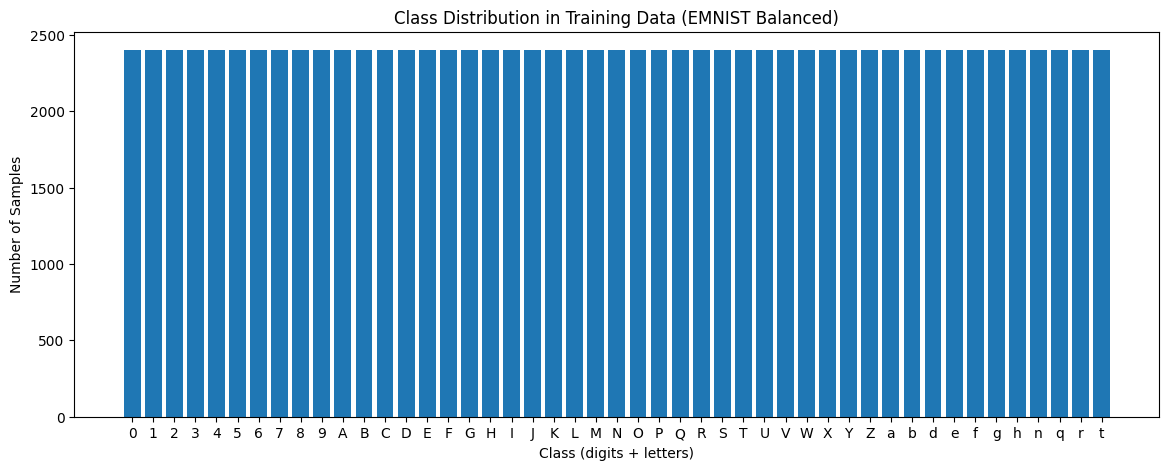

In [14]:
class_counts = train_data['label'].value_counts().sort_index()
label_names = [label_map[i] for i in class_counts.index]

plt.figure(figsize=(14, 5))
plt.bar(label_names, class_counts.values)
plt.xlabel("Class (digits + letters)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Data (EMNIST Balanced)")
plt.xticks(rotation=0)
plt.show()

In [15]:
def show_samples(X, y, labels=label_map, n=8):
    plt.figure(figsize=(12,3))
    limit = min(n, len(X))
    for i in range(limit):
        ax = plt.subplot(1, limit, i+1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        lbl = None
        if y is not None:
            # Support integer labels or one-hot vectors
            if hasattr(y, "ndim") and getattr(y, "ndim", 1) > 1:
                lbl = int(np.argmax(y[i]))
            else:
                lbl = int(y[i])
        if lbl is not None and labels:
            plt.title(labels[lbl])
        plt.axis('off')
    plt.show()

#Preprocessing

In [16]:
# Separate features and labels of training
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values


print("Features shape:", X_train.shape)
print("Labels shape:", y_train.shape)


Features shape: (112799, 784)
Labels shape: (112799,)


In [17]:
# Separate features and labels of testing
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

print("Features shape:", X_test.shape)
print("Labels shape:", y_test.shape)

Features shape: (18799, 784)
Labels shape: (18799,)


In [18]:

X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)


x_train shape:  (112799, 28, 28, 1)
x_test shape:  (18799, 28, 28, 1)


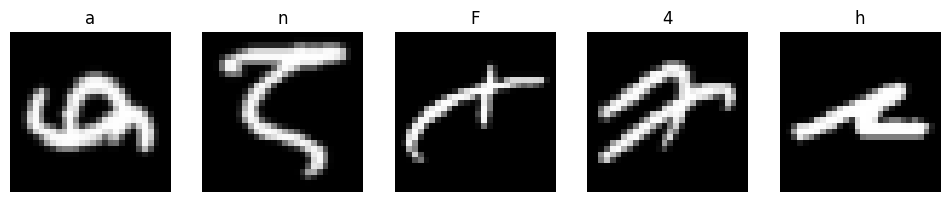

In [19]:
show_samples(X_train, y_train, n=5)

In [20]:
X_train = np.rot90(X_train, k=1, axes=(1,2))
X_test  = np.rot90(X_test,  k=1, axes=(1,2))

Visualizing some samples after rotation

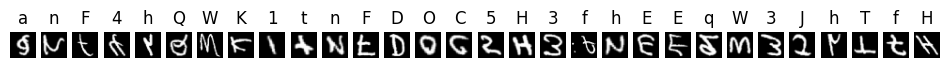

In [21]:
show_samples(X_train, y_train, n=30)

In [22]:
# Normlization
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

Shuffling the training dataset

In [23]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

Train & validation split

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (101519, 28, 28, 1) (101519,)
Validation set: (11280, 28, 28, 1) (11280,)


One Hot encoding

In [25]:
from tensorflow.keras.utils import to_categorical

# Balanced split labels start at 0; no offset needed
y_train = to_categorical(y_train, num_classes=num_classes)
y_val   = to_categorical(y_val,   num_classes=num_classes)
y_test  = to_categorical(y_test,  num_classes=num_classes)


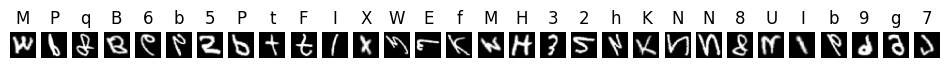

In [26]:
show_samples(X_train, y_train, n=30)

#VGG 19

In [27]:
# # import tensorflow as tf
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_vgg19_from_scratch(input_shape=(32, 32, 3), num_classes=26):
#     model_vgg = Sequential()

#     # Block 1
#     model_vgg.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
#     model_vgg.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Block 2
#     model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Block 3
#     model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Block 4
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Block 5
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Fully Connected Layers
#     model_vgg.add(Flatten())
#     model_vgg.add(Dense(4096, activation='relu'))
#     model_vgg.add(Dropout(0.5))
#     model_vgg.add(Dense(4096, activation='relu'))
#     model_vgg.add(Dropout(0.5))
#     model_vgg.add(Dense(num_classes, activation='softmax')) # For classification

#     return model_vgg

# model_vgg = build_vgg19_from_scratch()


# VGG-19

In [28]:
model_vgg = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model

In [29]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [30]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    )
]


In [ ]:
history = model_vgg.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,  # Increased for faster GPU training
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.6967 - loss: 1.0632 - val_accuracy: 0.8689 - val_loss: 0.3578
Epoch 2/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.8598 - loss: 0.4029 - val_accuracy: 0.8763 - val_loss: 0.3441
Epoch 3/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8725 - loss: 0.3517 - val_accuracy: 0.8820 - val_loss: 0.3253
Epoch 4/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8820 - loss: 0.3195 - val_accuracy: 0.8878 - val_loss: 0.3045
Epoch 5/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8899 - loss: 0.2915 - val_accuracy: 0.8894 - val_loss: 0.2993
Epoch 6/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8947 - loss: 0.2730 - val_accuracy: 0.8919 - val_loss: 0.2937
Epoch 7/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9028 - loss: 0.2516 - val_accuracy: 0.8887 - val_loss: 0.2980
Epoch 8/50
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9065 - loss: 

In [32]:
# save final model
model_vgg.save('final_emnist_vgg.h5')

Training & Validation Loss & Accuracy

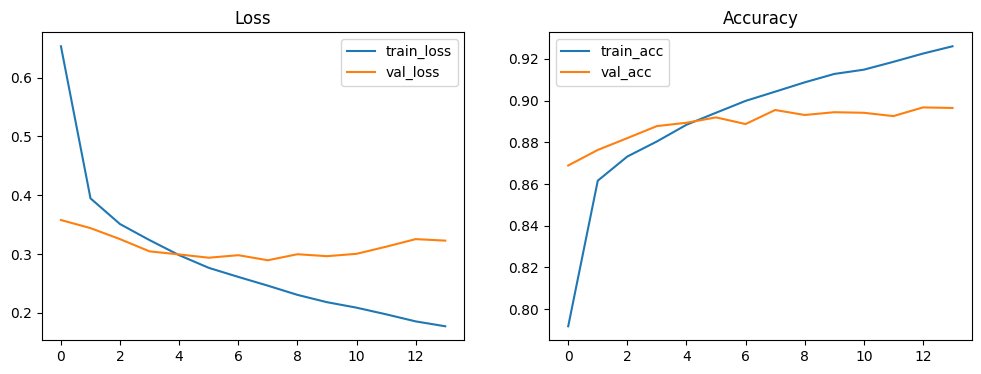

In [33]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

Final Evaluation on Validation/Test Set

In [34]:
val_loss, val_acc = model_vgg.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Loss: 0.2894
Validation Accuracy: 0.8955


<!-- Validation Loss: 0.2894
Validation Accuracy: 0.8955 -->

Classification Report

In [36]:
from sklearn.metrics import classification_report

# Generate predictions first
y_pred_proba = model_vgg.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

labels = label_map

print(
    classification_report(
        y_true,
        y_pred,
        target_names=labels
    )
)

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       400
           1       0.54      0.85      0.66       400
           2       0.95      0.87      0.91       400
           3       0.99      0.98      0.99       400
           4       0.95      0.95      0.95       400
           5       0.93      0.92      0.93       400
           6       0.91      0.96      0.93       400
           7       0.98      0.98      0.98       400
           8       0.95      0.98      0.97       400
           9       0.63      0.94      0.76       400
           A       0.97      0.98      0.98       400
           B       0.98      0.97      0.98       400
           C       0.97      0.97      0.97       400
           D       0.95      0.90      0.93       400
           E       0.98      0.99      0.98       400
           F       0.68      0.66      0.67       400
           G       0.92      0.97      0

ROC Curve

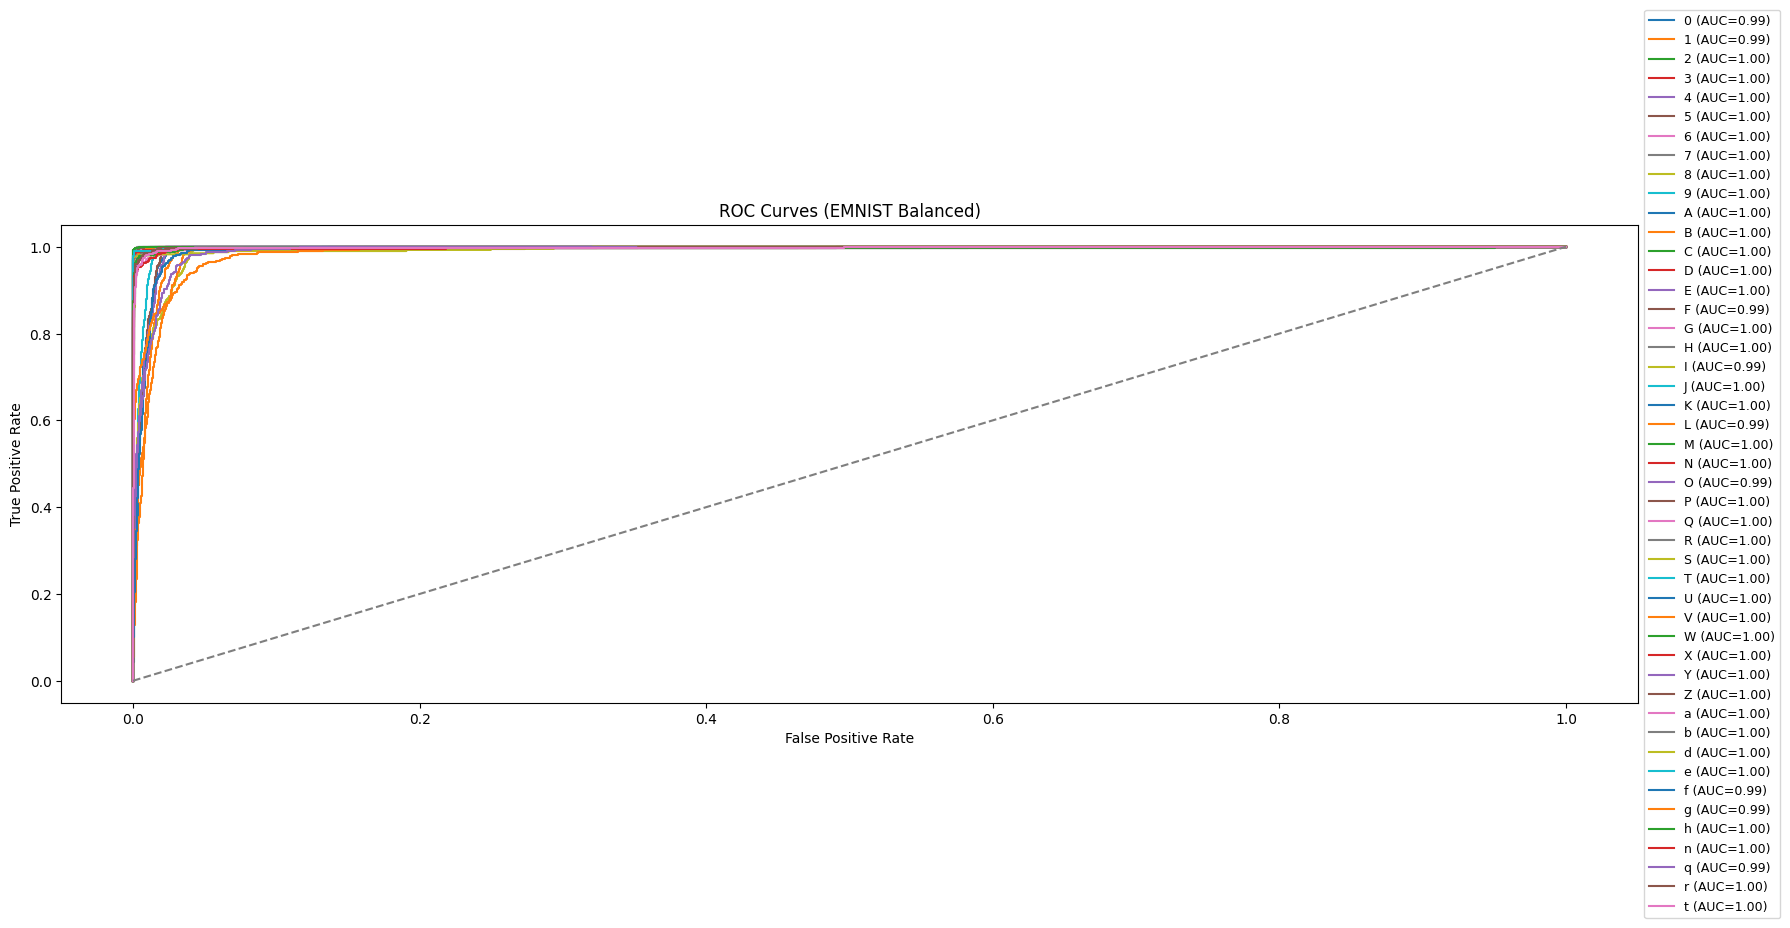

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute ROC curve and AUC for each class
if y_test.ndim == 1:
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))
else:
    y_test_onehot = y_test

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(18, 8))

for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f'{label_map[i]} (AUC={roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (EMNIST Balanced)')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=9
)
plt.tight_layout()
plt.show()

Sample Predictions Visualization

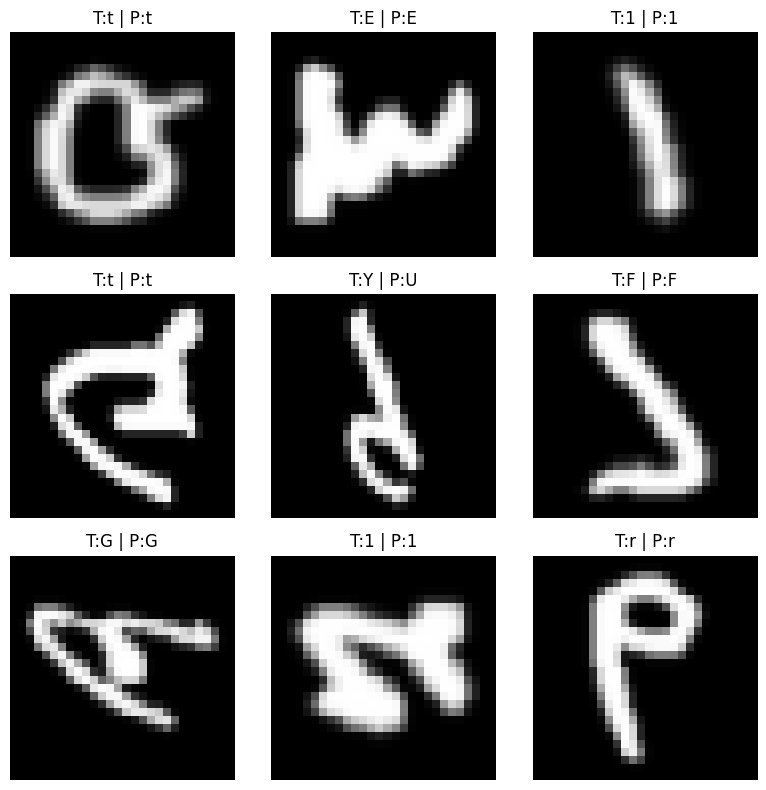

In [38]:
import random

indices = random.sample(range(len(X_val)), 9)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_val[idx].reshape(28,28), cmap='gray')
    true_label = label_map[y_true[idx]]
    pred_label = label_map[y_pred[idx]]
    plt.title(f"T:{true_label} | P:{pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Overfitting Diagnosis

In [39]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("Overfitting gap:", final_train_acc - final_val_acc)  #Excellent generalization


Overfitting gap: 0.029569804668426514


Confusion Matrix

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


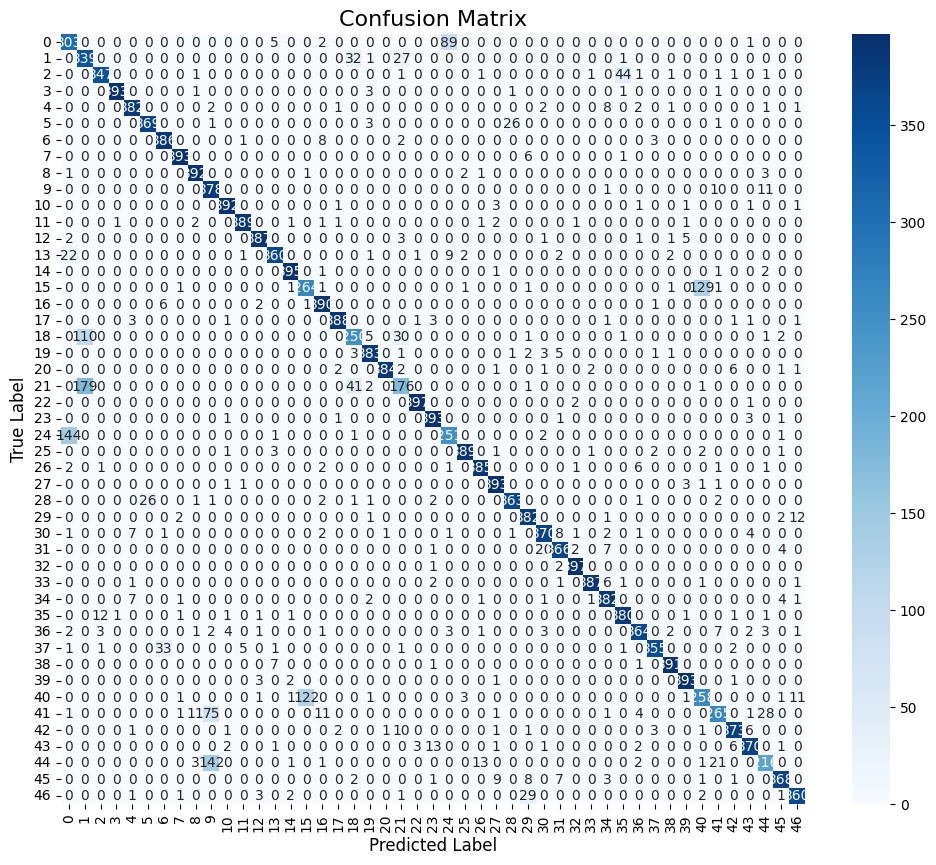

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
y_pred_proba = model_vgg.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 10})
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

Show some misclassified examples

Number of misclassified: 2011


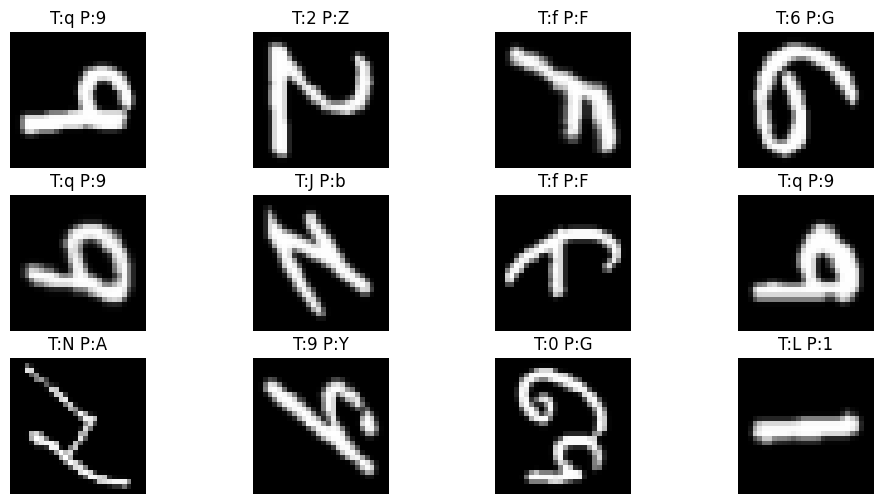

In [41]:
mis_idx = np.where(y_pred != y_true)[0]
print('Number of misclassified:', len(mis_idx))


n_show = min(12, len(mis_idx))
plt.figure(figsize=(12,6))
for i in range(n_show):
    idx = mis_idx[i]
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(X_test[idx].reshape(28, 28).T, cmap='gray')
    plt.title(f'T:{label_map[y_true[idx]]} P:{label_map[y_pred[idx]]}')
    plt.axis('off')
plt.show()

After optimizing some misclassified examples

Total misclassified: 2011


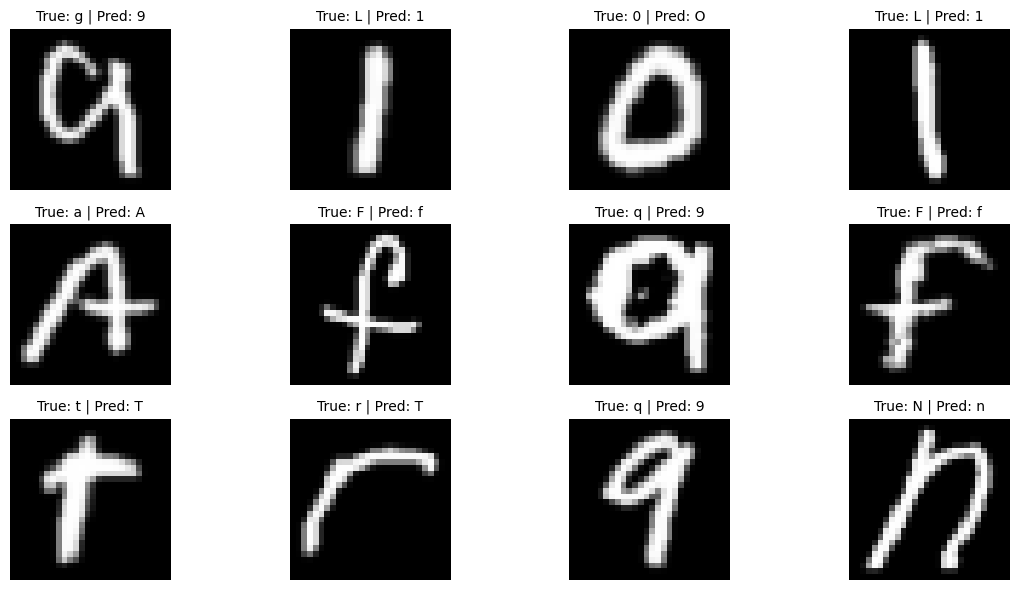

In [42]:
mis_idx = np.where(y_pred != y_true)[0]
np.random.shuffle(mis_idx)

print(f'Total misclassified: {len(mis_idx)}')
n_show = min(12, len(mis_idx))
plt.figure(figsize=(12, 6))
for i in range(n_show):
    idx = mis_idx[i]
    ax = plt.subplot(3, 4, i + 1)
    img = X_test[idx].reshape(28, 28)
    img = np.rot90(img.T, k=1)
    plt.imshow(img, cmap='gray')

    true_char = label_map[y_true[idx]]
    pred_char = label_map[y_pred[idx]]

    plt.title(f'True: {true_char} | Pred: {pred_char}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

This indicates that about 5% of EMNIST letters dataset looks like the messy examples above.

# Vision Transformer (ViT) Model

## 📚 What is ViT?

**Vision Transformer (ViT)** treats images as sequences of patches and applies the Transformer architecture (originally designed for NLP) to computer vision.

### Key Concepts:

1. **Patch Embedding**: Split image into fixed-size patches (e.g., 4×4) and flatten each to a 1D vector
2. **Position Encoding**: Add learnable position embeddings so the model knows patch locations
3. **Transformer Encoder**: Use self-attention to learn relationships between patches
4. **Classification Head**: Global pooling + MLP for final predictions

### Advantages:
- ✅ Captures long-range dependencies better than CNNs
- ✅ Scales well with data (better with large datasets)
- ✅ No inductive biases (learns spatial relationships from scratch)

### Trade-offs:
- ⚠️ Requires more data than CNNs (less effective on small datasets like EMNIST)
- ⚠️ Computationally expensive (more parameters/FLOPs)
- ⚠️ Needs careful hyperparameter tuning

## 🔍 Code Explanation

### Architecture Breakdown:

```
Input (28×28×1) 
  ↓
📦 Patch Embedding (Conv2D stride=4)
  → Converts 28×28 into 7×7=49 patches
  → Each patch: 64-dim embedding
  ↓
📍 Position Embedding (Learnable)
  → Adds spatial information to each patch
  ↓
🔄 Transformer Blocks (×4)
  ├─ LayerNorm
  ├─ Multi-Head Attention (4 heads)
  │   └─ Learns patch relationships
  ├─ Residual Connection
  ├─ LayerNorm
  ├─ MLP (128→64 dims, GELU activation)
  └─ Residual Connection
  ↓
🎯 Classification Head
  ├─ Global Average Pooling
  ├─ MLP (256→128 dims)
  └─ Dense(num_classes, softmax)
```

### Current Configuration:
- **Patches**: 49 (7×7 grid, each 4×4 pixels)
- **Embedding dim**: 64
- **Attention heads**: 4
- **Transformer layers**: 4
- **MLP units**: [128, 64] internal, [256, 128] head
- **Parameters**: ~180K (lightweight for ViT)

In [43]:
# Vision Transformer (ViT) for EMNIST balanced (28x28x1 → digits + letters)
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def create_vit_classifier(
    input_shape=(28, 28, 1),
    num_classes=None,
    image_size=28,
    patch_size=4,           # 28 / 4 = 7 → 49 patches
    projection_dim=64,
    transformer_layers=4,
    num_heads=4,
    transformer_units=[128, 64],   # MLP inside transformer
    mlp_head_units=[256, 128],     # final classification head
    dropout_rate=0.1
):
    num_classes = num_classes or globals().get("num_classes", 47)
    inputs = keras.Input(shape=input_shape)

    # 1) Patch embedding using a Conv2D with stride = patch_size
    x = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid"
    )(inputs)

    # Flatten patches: (batch, num_patches, projection_dim)
    num_patches = (image_size // patch_size) ** 2  # 49
    x = layers.Reshape((num_patches, projection_dim))(x)

    # 2) Add learnable positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding_layer = layers.Embedding(
        input_dim=num_patches,
        output_dim=projection_dim
    )
    position_embeddings = pos_embedding_layer(positions)
    x = x + position_embeddings  # broadcast over batch

    # 3) Transformer encoder blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=dropout_rate
        )(x1, x1)

        x2 = layers.Add()([attention_output, x])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in transformer_units:
            x3 = layers.Dense(units, activation="gelu")(x3)
            x3 = layers.Dropout(dropout_rate)(x3)
        x = layers.Add()([x2, x3])

    # 4) Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)

    for units in mlp_head_units:
        x = layers.Dense(units, activation="gelu")(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="vit_emnist_balanced")
    return model

# Instantiate the ViT model
model = create_vit_classifier(
    input_shape=(28, 28, 1),
    num_classes=num_classes
)

# Compile it (you can tweak optimizer/lr later)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "vit_emnist_balanced"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 7, 7, 64)  │      1,088 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 64)    │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 64)    │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 49, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 49, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 49, 64)    │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 49, 64)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 49, 64)    │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 49, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 49, 64)    │      8,256 │ dropout_5[0][0] 

 Total params: 389,615 (1.49 MB)

 Trainable params: 389,615 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
print("X_train min:", X_train.min(), " max:", X_train.max())
print("X_val min:", X_val.min(), " max:", X_val.max())

X_train min: 0.0  max: 1.0
X_val min: 0.0  max: 1.0


In [45]:
print(y_train.shape)
print(y_train[:10])


(101519, 47)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

callbacks = [early_stop, reduce_lr]

# Steps per epoch
steps_per_epoch = len(X_train) // 64 // 2

#  Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


793/793 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.1038 - loss: 3.3000 - val_accuracy: 0.4500 - val_loss: 1.7407 - learning_rate: 0.0010
Epoch 2/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4748 - loss: 1.6779 - val_accuracy: 0.6092 - val_loss: 1.1909 - learning_rate: 0.0010
Epoch 3/50
  1/793 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5938 - loss: 1.2133

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.2133 - val_accuracy: 0.6078 - val_loss: 1.2115 - learning_rate: 0.0010
Epoch 4/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6018 - loss: 1.2542 - val_accuracy: 0.6817 - val_loss: 0.9405 - learning_rate: 0.0010
Epoch 5/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6574 - loss: 1.0466 - val_accuracy: 0.7060 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 6/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 1.2545 - val_accuracy: 0.7090 - val_loss: 0.8739 - learning_rate: 0.0010
Epoch 7/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.6949 - loss: 0.9190 - val_accuracy: 0.7442 - val_loss: 0.7638 - learning_rate: 0.0010
Epoch 8/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7108 - loss: 0.8510 - val_accuracy: 0.7246 - val_loss: 0.8002 - learning_rate: 0.0010
Epoch 9/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6719 - loss: 0.7872 - val

Evaluations

Test Loss: 0.4277
Test Accuracy: 0.8518
588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


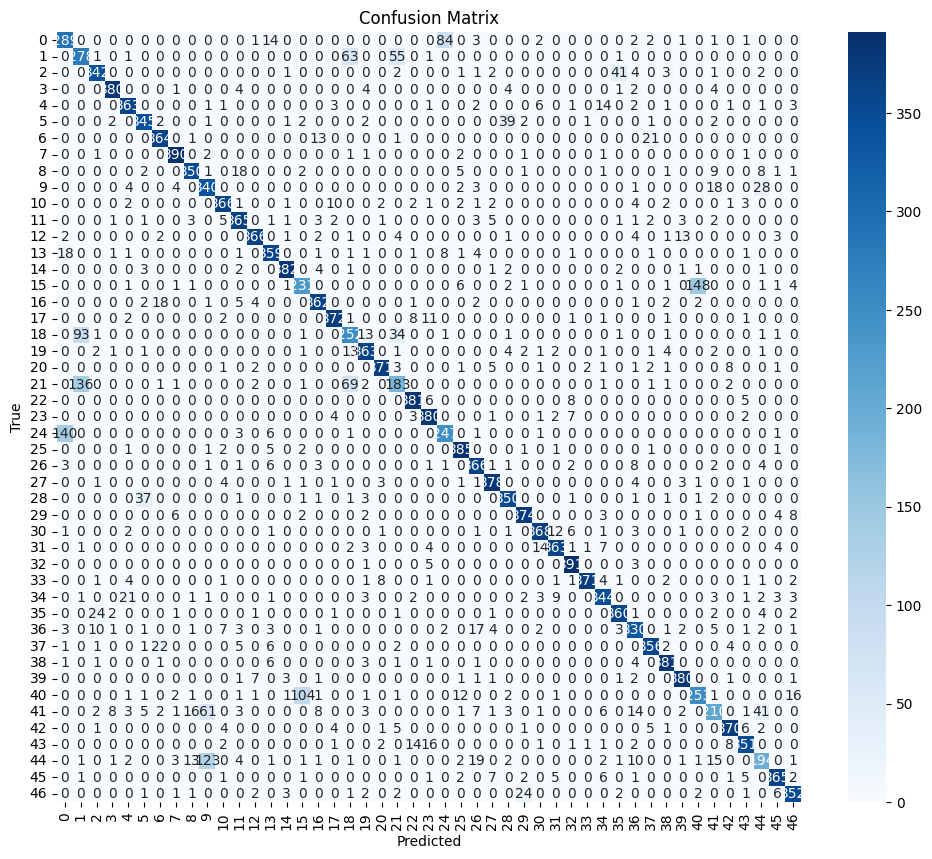

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.72      0.67       400
           1       0.54      0.69      0.61       400
           2       0.88      0.85      0.87       400
           3       0.96      0.95      0.95       400
           4       0.89      0.91      0.90       400
           5       0.86      0.86      0.86       400
           6       0.88      0.91      0.90       400
           7       0.95      0.97      0.96       400
           8       0.90      0.88      0.89       400
           9       0.64      0.85      0.73       400
           A       0.92      0.92      0.92       400
           B       0.87      0.91      0.89       400
           C       0.95      0.92      0.93       400
           D       0.88      0.90      0.89       400
           E       0.96      0.95      0.96       400
           F       0.66      0.58      0.62       400
           G       0.90      0.91      0.90       400
   

/tmp/ipython-input-565931855.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


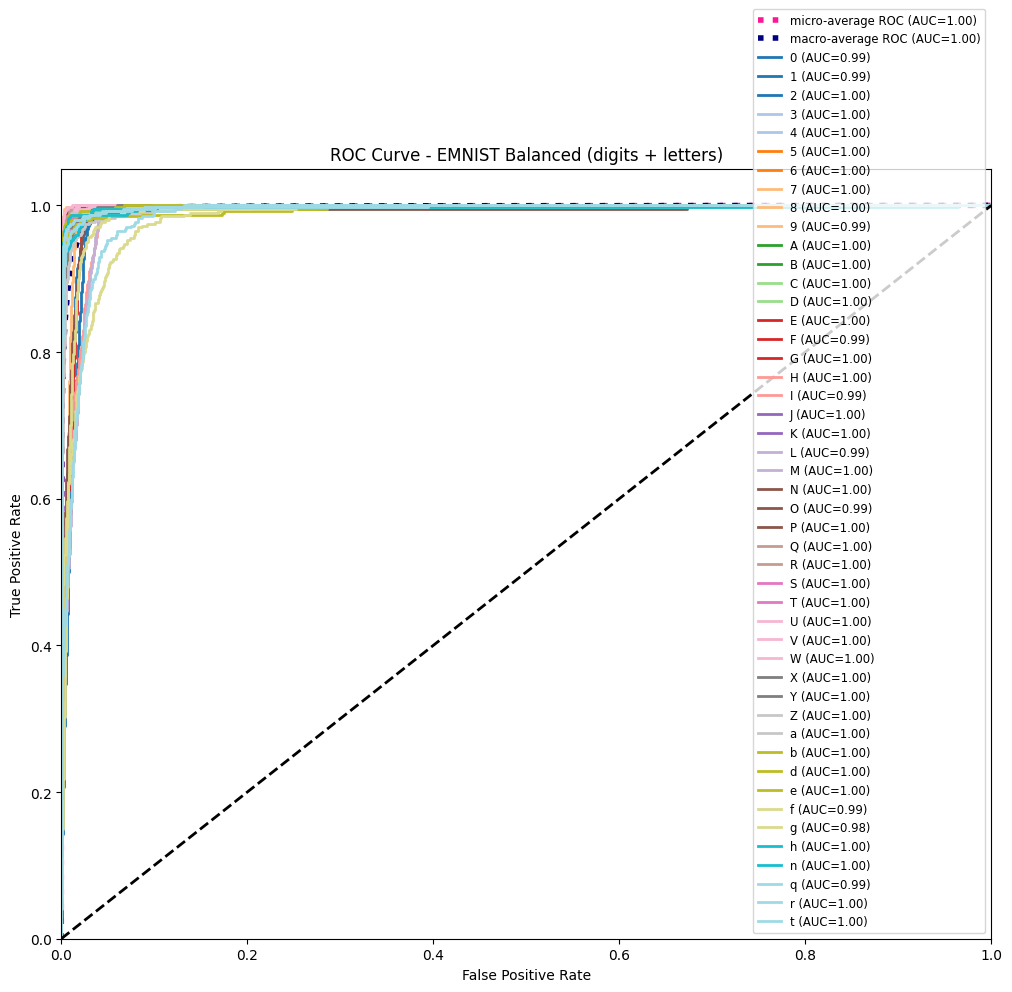

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

#  Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

#  Predictions
y_pred_probs = model.predict(X_test)

# Convert y_test to labels if One-Hot
if y_test.ndim == 2:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

y_pred_labels = np.argmax(y_pred_probs, axis=1)

#  Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_test_labels, y_pred_labels, target_names=label_map)
print("Classification Report:\n", report)

#  ROC Curve (Multi-class)
if y_test.ndim == 1:
    y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))
else:
    y_test_onehot = y_test

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC Curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC={roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'macro-average ROC (AUC={roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

colors = plt.cm.get_cmap('tab20', num_classes)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label_map[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EMNIST Balanced (digits + letters)')
plt.legend(loc="lower right", fontsize='small')
plt.show()


<!-- Test Loss: 0.2911
Test Accuracy: 0.9001 -->

<!-- accuracy                           0.90     14799
   macro avg       0.67      0.66      0.66     14799
weighted avg       0.91      0.90      0.90     14799 -->

# 🚀 Interactive Gradio Web App for EMNIST Classification

In [48]:
!pip install gradio

In [ ]:
import gradio as gr
import tensorflow as tf
import cv2
import numpy as np

model_path = 'final_emnist_vgg.h5'
try:
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully!")
except:
    print("⚠️ Model file 'final_emnist_vgg.h5' not found. Please upload it.")

class_names = label_map


def predict_char(image):
    if image is None:
        return None

    if isinstance(image, dict):
        image = image['composite']

    image = np.array(image)

    if len(image.shape) == 3 and image.shape[2] == 4:
        alpha_channel = image[:, :, 3]
        rgb_channels = image[:, :, :3]

        white_background = np.ones_like(rgb_channels, dtype=np.uint8) * 255

        alpha_factor = alpha_channel[:, :, np.newaxis] / 255.0
        image = rgb_channels * alpha_factor + white_background * (1 - alpha_factor)
        image = image.astype(np.uint8)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    image = cv2.resize(image, (28, 28))

    if np.mean(image) > 127:
        image = 255 - image

    image = image.astype('float32') / 255.0
    image = image.reshape(1, 28, 28, 1)

    # Prediction
    prediction = model.predict(image, verbose=0)[0]
    confidences = {class_names[i]: float(prediction[i]) for i in range(num_classes)}

    return confidences


interface = gr.Interface(
    fn=predict_char,
    inputs=gr.Sketchpad(label="Draw your character here", type="numpy"),
    outputs=gr.Label(num_top_classes=min(3, num_classes)),
    live=True,
    title="EMNIST Balanced Classifier 🔠",
    description="Draw any digit or letter from the EMNIST balanced set."
)

# Launch without blocking other cells; stop with interface.close()
interface.launch(
    share=True,
    debug=True,
    prevent_thread_lock=True,
    inline=False
)

✅ Model loaded successfully!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c2f97001bbda676926.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1698, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 61, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

content_type multipart/form-data; boundary=----WebKitFormBoundaryThru1ns4hA54fC9P
content_type multipart/form-data; boundary=----WebKitFormBoundaryeP07MXjJxs7TH34B
content_type multipart/form-data; boundary=----WebKitFormBoundarytpMb0f2dBUzELrrA


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1698, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 61, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

content_type multipart/form-data; boundary=----WebKitFormBoundaryy5RWaJfw6BqrXQZg
content_type multipart/form-data; boundary=----WebKitFormBoundaryu6MXP7rAPq2vgWnQ
content_type multipart/form-data; boundary=----WebKitFormBoundarygkPdFZABqho0h5jM
content_type multipart/form-data; boundary=----WebKitFormBoundaryuTy0czzxm03rrHWT
content_type multipart/form-data; boundary=----WebKitFormBoundaryt7y4Xot34W2Ji4kh
content_type multipart/form-data; boundary=----WebKitFormBoundaryedmsdfDbCItx4Qvf
content_type multipart/form-data; boundary=----WebKitFormBoundary9A1Bj4T6R4CZAEYT
content_type multipart/form-data; boundary=----WebKitFormBoundarykAyBJohSDQ7RlG1f
content_type multipart/form-data; boundary=----WebKitFormBoundaryh7qT03LodAx9K13u
content_type multipart/form-data; boundary=----WebKitFormBoundaryKA0VFYB90CU7HS5G
content_type multipart/form-data; boundary=----WebKitFormBoundaryoHO0HQf2oAtABOzB
content_type multipart/form-data; boundary=----WebKitFormBoundaryUGTPKKDaEDr88Agd
content_type mul

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1698, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 61, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

content_type multipart/form-data; boundary=----WebKitFormBoundaryxsypXRKBfF5VXCet
content_type multipart/form-data; boundary=----WebKitFormBoundaryLmA4cAAATvNApmZg
content_type multipart/form-data; boundary=----WebKitFormBoundaryeqHntnOuEA9YH9WA
content_type multipart/form-data; boundary=----WebKitFormBoundaryegG70CAXDoHkZlXc
content_type multipart/form-data; boundary=----WebKitFormBoundarybAwlaeZz5BFoRPsH
content_type multipart/form-data; boundary=----WebKitFormBoundaryEBXARimXADNtBbO8
content_type multipart/form-data; boundary=----WebKitFormBoundaryrwcDBNxVvqIpqjCT
content_type multipart/form-data; boundary=----WebKitFormBoundaryiO2IaA9qjBzpEAT7
content_type multipart/form-data; boundary=----WebKitFormBoundaryyIreKFdEkBA9eWXO
content_type multipart/form-data; boundary=----WebKitFormBoundaryuLWkWiBGIZC2WB5Q
content_type multipart/form-data; boundary=----WebKitFormBoundaryf5KSwUqJNDPIYx8F
content_type multipart/form-data; boundary=----WebKitFormBoundaryRuDbADz7K4AMU8jv
content_type mul

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1698, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 61, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

content_type multipart/form-data; boundary=----WebKitFormBoundaryAp5Zi6IfgbglgbJT
content_type multipart/form-data; boundary=----WebKitFormBoundaryzDQPENdnCki4M537
content_type multipart/form-data; boundary=----WebKitFormBoundary0z3IKBLwxd9bhzB5
content_type multipart/form-data; boundary=----WebKitFormBoundaryAucDKN1rMLJ01wxO
content_type multipart/form-data; boundary=----WebKitFormBoundaryScKOnY7BxycjJBWy
content_type multipart/form-data; boundary=----WebKitFormBoundaryls7W4kbtlB7Eh2Gy
content_type multipart/form-data; boundary=----WebKitFormBoundaryxxvuybFTLsoOHYmf
content_type multipart/form-data; boundary=----WebKitFormBoundaryldWgh2Px8CRqqIsI
content_type multipart/form-data; boundary=----WebKitFormBoundaryIVGlJRlwhFhzujDk
content_type multipart/form-data; boundary=----WebKitFormBoundary3Patrk0mchyBivrf
content_type multipart/form-data; boundary=----WebKitFormBoundary5Am1BjHl1FrpU93m
content_type multipart/form-data; boundary=----WebKitFormBoundarynnh3IRvZkaFnWHlv
content_type mul

In [ ]:
interface.close()